# Experimenting with Projection Ensembles

#### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from chex.inference import 

from chex import config as C
from chex.dataaug import get_transforms
from chex.dataload import CheXDataset, subset_dloader, get_dloaders, get_pdloaders
from chex.etl import proc_df, make_df_merged
from chex.inference import validation_ensemble, ensemble, predict_loader, pseudo_ensemble, load_predict
from chex.metrics import classwise_rocauc
from chex.modeling import CheXModel
from chex.plotting import show_batch, plot_learning_curves
from chex.saving import save_history, save_trained, load_trained, make_desc
from chex.training import Trainer, make_trainer
from chex.utils import seed_everything, recurse_children

C:\Users\Rygu\Anaconda3\envs\mldl\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


#### Global Setup

In [3]:
USE_CUDA = True
ON_AWS = False#True
NUM_WORKERS = 4 if ON_AWS else 0

DEVICE = torch.device('cuda' if torch.cuda.is_available() and USE_CUDA else 'cpu')
C.set_config(USE_CUDA=USE_CUDA, ON_AWS=ON_AWS, NUM_WORKERS=NUM_WORKERS, DEVICE=DEVICE)

In [4]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

## Data

In [5]:
df_master = pd.read_csv(C.DATA_PATH/'Team68_CheXpert_Full.csv').set_index('CheX_Image_ID')
df_psample = pd.read_csv(C.DATA_PATH/'Team68_Sample_001.csv').rename({'chex_image_id':'CheX_Image_ID'},axis=1).set_index('CheX_Image_ID')

In [6]:
df_master.head()

,Dataset_ID,patient_id,gender,study,view_num,age_num,ap_pa_ll,Path,No_Finding,Enlarged_Cardiomediastinum,...,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
CheX_Image_ID,,,,,,,,,,,,,,,,,,,,,
162,1,56,M,1,1,88,AP,CheXpert-v1.0-small/train/patient00056/study1/...,NaN,NaN,...,NaN,NaN,0.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN
589,1,146,F,24,1,74,AP,CheXpert-v1.0-small/train/patient00146/study24...,NaN,NaN,...,NaN,1.0,-1.0,NaN,-1.0,NaN,1.0,NaN,NaN,1.0
791,1,201,M,2,2,46,LL,CheXpert-v1.0-small/train/patient00201/study2/...,NaN,-1.0,...,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
825,1,207,M,1,1,36,AP,CheXpert-v1.0-small/train/patient00207/study1/...,NaN,0.0,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
826,1,208,M,1,1,68,AP,CheXpert-v1.0-small/train/patient00208/study1/...,NaN,1.0,...,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,1.0


In [7]:
df_psample.head()

,Pop_ID,Posit_ID
CheX_Image_ID,,
4,1,1
5,1,1
8,1,2
9,1,3
12,1,1


### Full Dataset Processing

In [6]:
df_pmaster = proc_df(df_master.assign(Pop_ID=df_master['Dataset_ID'], Posit_ID=df_master['ap_pa_ll'].map({'AP':1,'PA':2,'LL':3})))[[*df_psample.columns]+['Path']+C.TARGET_LABELS]
df_full_train, df_full_valid = (df_pmaster[df_pmaster['Pop_ID'].eq(i)] for i in [1,2])
test_loader_full = subset_dloader(df_full_valid, None, False, batch_size=256, print_tfms=False) 

In [128]:
df_trnvaltst

,Pop_ID,Posit_ID,Path,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
CheX_Image_ID,,,,,,,,,,,,,,,,,
4,1,1,CheXpert-v1.0-small/train/patient00002/study2/...,0.0,0.0,0.567301,1.0,0.0,0.766516,0.683054,0.0,0.787481,0.0,0.67105,0.0,1.0,0.0
5,1,1,CheXpert-v1.0-small/train/patient00003/study1/...,0.0,0.0,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
8,1,2,CheXpert-v1.0-small/train/patient00005/study1/...,1.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,1.0
9,1,3,CheXpert-v1.0-small/train/patient00005/study1/...,1.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,1.0
12,1,1,CheXpert-v1.0-small/train/patient00006/study1/...,1.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221577,3,3,CheXpert-v1.0-small/valid/patient64625/study1/...,1.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
221657,3,1,CheXpert-v1.0-small/valid/patient64703/study1/...,0.0,0.0,0.000000,1.0,0.0,0.000000,1.000000,0.0,1.000000,0.0,1.00000,0.0,0.0,1.0
221574,3,1,CheXpert-v1.0-small/valid/patient64623/study1/...,0.0,1.0,1.000000,1.0,0.0,1.000000,1.000000,0.0,1.000000,0.0,1.00000,0.0,0.0,1.0


### Sample Dataset Processing

In [7]:
df_hotest = df_master.loc[df_master['Dataset_ID'] == 2].copy()
df_hotest = df_hotest.assign(Pop_ID=3, Posit_ID=df_hotest['ap_pa_ll'].map({'AP':1,'PA':2,'LL':3}))

In [8]:
df_trnvaltst = proc_df(df_psample.join(df_master).append(df_hotest)[[*df_psample.columns]+['Path']+C.TARGET_LABELS])

In [9]:
df_train,df_valid,df_test = (df_trnvaltst[df_trnvaltst['Pop_ID'].eq(i)] for i in range(1,4))
dfs_tvt = [df_train,df_valid,df_test]

In [17]:
df_test

,Pop_ID,Posit_ID,Path,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
CheX_Image_ID,,,,,,,,,,,,,,,,,
221521,3,1,CheXpert-v1.0-small/valid/patient64585/study1/...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221477,3,1,CheXpert-v1.0-small/valid/patient64552/study1/...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
221663,3,1,CheXpert-v1.0-small/valid/patient64708/study1/...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221472,3,1,CheXpert-v1.0-small/valid/patient64548/study1/...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
221695,3,1,CheXpert-v1.0-small/valid/patient64740/study1/...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221577,3,3,CheXpert-v1.0-small/valid/patient64625/study1/...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221657,3,1,CheXpert-v1.0-small/valid/patient64703/study1/...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
221574,3,1,CheXpert-v1.0-small/valid/patient64623/study1/...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [8]:
test_loader1,test_loader2,test_loader3 = (subset_dloader(df_test,i,False,grp_name='Posit_ID',batch_size=256,print_tfms=False) for i in [1,2,3])
test_loaders = [test_loader1,test_loader2,test_loader3]

## Experiments

In [11]:
gidmap = {1:'AP', 2:'PA', 3:'LL'}

In [155]:
def train_group(df_train, df_valid, grp_id, grp_name='Posit_ID', batch_size=256, unq=''):
    train_loader, valid_loader = get_pdloaders(df_train, df_valid, grp_id, grp_name, batch_size, print_tfms=False)
    nsamp = str(len(train_loader.dataset)/1000).split('.')[0]

    n_epochs = 5
    savename=f'dn121_{gidmap[grp_id]}_{nsamp}k_{n_epochs}e'+unq

    criterion = nn.BCELoss()
    model = CheXModel('densenet121',use_sig=True)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    thaw_schd = {2:('norm5','denseblock4'), 3:('transition3','denseblock3')}
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [1,2,3], gamma=0.1, verbose=True)

    trainer = Trainer(model, optimizer, criterion, scheduler, thaw_schd, device=DEVICE)
    pstat = trainer.freeze(['_fc','fc','network.classifier','classifier',],invert_match=True)

    hist = trainer.train(train_loader, valid_loader, n_epochs, log_freq=10, save_name=f'{savename}_chkpnt')
    save_desc = make_desc(train_loader, trainer, f"{n_epochs}e, {gidmap[grp_id]}({grp_id}) projections only")
    save_history(trainer.history, savename, save_desc)
    return trainer,savename

### Sampled Data

In [14]:
#df_train, df_valid = df_train, df_valid
samp_savenames = []

#### Group = AP(1)

In [29]:
grp_id = 1
trainer,savename = train_group(df_train, df_valid, grp_id)
samp_savenames.append(f'{savename}_chkpnt')

Adjusting learning rate of group 0 to 1.0000e-02.
Trainable: 1, Frozen: 241


Score improved: 0.82552 > 0.00000
state dict saved to: save/models/dn121_AP_72k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [0] train_loss: 0.4134, train_auc: 0.8149, train_auc5: 0.6871, valid_loss: 0.3932, valid_auc: 0.8255, valid_auc5: 0.7247


Score improved: 0.82687 > 0.82552
state dict saved to: save/models/dn121_AP_72k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [1] train_loss: 0.3817, train_auc: 0.8339, train_auc5: 0.7206, valid_loss: 0.3923, valid_auc: 0.8269, valid_auc5: 0.7157
Trainable: 66, Frozen: 176


Score improved: 0.84924 > 0.82687
state dict saved to: save/models/dn121_AP_72k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [2] train_loss: 0.3723, train_auc: 0.8433, train_auc5: 0.7413, valid_loss: 0.3654, valid_auc: 0.8492, valid_auc5: 0.7590
Trainable: 164, Frozen: 78


Score improved: 0.85213 > 0.84924
state dict saved to: save/models/dn121_AP_72k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [3] train_loss: 0.3657, train_auc: 0.8510, train_auc5: 0.7589, valid_loss: 0.3647, valid_auc: 0.8521, valid_auc5: 0.7639


Score improved: 0.85443 > 0.85213
state dict saved to: save/models/dn121_AP_72k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [4] train_loss: 0.3608, train_auc: 0.8548, train_auc5: 0.7663, valid_loss: 0.3615, valid_auc: 0.8544, valid_auc5: 0.7697

File saved to: save/histories/dn121_AP_72k_5e.pkl


In [37]:
#last epoch time: train=~8m, valid=~2m
print('Full Test - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader_full)))
print(f'Group{grp_id}'+' Test - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loaders[grp_id-1])))

Full Test - Loss: 0.39578, AUC: 0.81785


Group1 Test - Loss: 0.43139, AUC: 0.83316


#### Group = PA(2)

In [84]:
grp_id = 2
trainer,savename = train_group(df_train, df_valid, grp_id)
samp_savenames.append(f'{savename}_chkpnt')

Adjusting learning rate of group 0 to 1.0000e-02.
Trainable: 1, Frozen: 241


Score improved: 0.74008 > 0.00000
state dict saved to: save/models/dn121_PA_13k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [0] train_loss: 0.4625, train_auc: 0.6860, train_auc5: 0.6695, train_time: 58.6928, valid_loss: 0.3740, valid_auc: 0.7401, valid_auc5: 0.7403, valid_time: 23.0439


Score improved: 0.75304 > 0.74008
state dict saved to: save/models/dn121_PA_13k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [1] train_loss: 0.3630, train_auc: 0.7515, train_auc5: 0.7450, train_time: 63.3577, valid_loss: 0.3607, valid_auc: 0.7530, valid_auc5: 0.7527, valid_time: 25.7046
Trainable: 66, Frozen: 176


Score improved: 0.77362 > 0.75304
state dict saved to: save/models/dn121_PA_13k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [2] train_loss: 0.3550, train_auc: 0.7658, train_auc5: 0.7608, train_time: 68.4375, valid_loss: 0.3500, valid_auc: 0.7736, valid_auc5: 0.7778, valid_time: 25.8108
Trainable: 164, Frozen: 78


Score improved: 0.77817 > 0.77362
state dict saved to: save/models/dn121_PA_13k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [3] train_loss: 0.3476, train_auc: 0.7788, train_auc5: 0.7790, train_time: 93.7809, valid_loss: 0.3470, valid_auc: 0.7782, valid_auc5: 0.7831, valid_time: 24.5240


Score improved: 0.78063 > 0.77817
state dict saved to: save/models/dn121_PA_13k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [4] train_loss: 0.3450, train_auc: 0.7833, train_auc5: 0.7842, train_time: 93.2016, valid_loss: 0.3451, valid_auc: 0.7806, valid_auc5: 0.7866, valid_time: 24.4921

File saved to: save/histories/dn121_PA_13k_5e.pkl


In [86]:
print('Full Test - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader_full)))
print(f'Group{grp_id}'+' Test - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loaders[grp_id-1])))

Full Test - Loss: 0.42126, AUC: 0.80436


Group2 Test - Loss: 0.23064, AUC: 0.87132


#### Group = LL(3)

In [24]:
grp_id = 3
trainer,savename = train_group(df_train, df_valid, grp_id)
samp_savenames.append(f'{savename}_chkpnt')

Adjusting learning rate of group 0 to 1.0000e-02.
Trainable: 1, Frozen: 241


Score improved: 0.72900 > 0.00000
state dict saved to: save/models/dn121_LL_14k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [0] train_loss: 0.4694, train_auc: 0.6867, train_auc5: 0.6513, valid_loss: 0.3890, valid_auc: 0.7290, valid_auc5: 0.7257


Score improved: 0.74961 > 0.72900
state dict saved to: save/models/dn121_LL_14k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [1] train_loss: 0.3741, train_auc: 0.7459, train_auc5: 0.7247, valid_loss: 0.3721, valid_auc: 0.7496, valid_auc5: 0.7291
Trainable: 66, Frozen: 176


Score improved: 0.76900 > 0.74961
state dict saved to: save/models/dn121_LL_14k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [2] train_loss: 0.3666, train_auc: 0.7602, train_auc5: 0.7429, valid_loss: 0.3589, valid_auc: 0.7690, valid_auc5: 0.7607
Trainable: 164, Frozen: 78


Score improved: 0.77364 > 0.76900
state dict saved to: save/models/dn121_LL_14k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [3] train_loss: 0.3560, train_auc: 0.7773, train_auc5: 0.7644, valid_loss: 0.3565, valid_auc: 0.7736, valid_auc5: 0.7669


Score improved: 0.77536 > 0.77364
state dict saved to: save/models/dn121_LL_14k_5e_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [4] train_loss: 0.3536, train_auc: 0.7811, train_auc5: 0.7703, valid_loss: 0.3552, valid_auc: 0.7754, valid_auc5: 0.7686

File saved to: save/histories/dn121_LL_14k_5e.pkl


In [28]:
# validation time ~ 25s @ 1e-5
print('Full Test - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader_full)))
print(f'Group{grp_id}'+' Test - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loaders[grp_id-1])))

Full Test - Loss: 0.45386, AUC: 0.76536


Group3 Test - Loss: 0.45673, AUC: 0.76066


#### Ensemble 

In [130]:
print(samp_savenames)

['dn121_AP_72k_5e_chkpnt', 'dn121_PA_13k_5e_chkpnt', 'dn121_LL_14k_5e_chkpnt']


In [151]:
base_model = CheXModel('densenet121',use_sig=True)
df_ens = ensemble(base_model, samp_savenames, test_loader_full, sigmoid=False, device=DEVICE)
ensauc = roc_auc_score(test_loader_full.dataset.labels, df_ens.values, average='micro', multi_class='ovo')
print('ensemble auc:',ensauc)


ensemble auc: 0.8196709839410827


#### Pseudo-Ensemble

In [150]:
base_model = CheXModel('densenet121',use_sig=True)
df_psens,df_lbls = pseudo_ensemble(base_model, samp_savenames, test_loaders, sigmoid=False, device=DEVICE)
psensauc =roc_auc_score(df_lbls.values, df_psens.values, average='micro', multi_class='ovo')
print('pseudo-ensemble auc:',psensauc)


pseudo-ensemble auc: 0.8444683930165964


### Full Dataset

In [152]:
full_savenames = []

#### Group = AP(1)

In [156]:
grp_id = 1
trainer,savename = train_group(df_full_train, df_full_valid, grp_id, unq='full')
full_savenames.append(f'{savename}_chkpnt')

Adjusting learning rate of group 0 to 1.0000e-02.
Trainable: 1, Frozen: 241


Score improved: 0.78343 > 0.00000
state dict saved to: save/models/dn121_AP_160k_5efull_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [0] train_loss: 0.3986, train_auc: 0.8234, train_auc5: 0.7042, train_time: 679.4817, valid_loss: 0.4748, valid_auc: 0.7834, valid_auc5: 0.6692, valid_time: 1.7801


Score improved: 0.81162 > 0.78343
state dict saved to: save/models/dn121_AP_160k_5efull_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [1] train_loss: 0.3791, train_auc: 0.8368, train_auc5: 0.7256, train_time: 689.5938, valid_loss: 0.4555, valid_auc: 0.8116, valid_auc5: 0.7200, valid_time: 1.7634
Trainable: 66, Frozen: 176


Score improved: 0.83410 > 0.81162
state dict saved to: save/models/dn121_AP_160k_5efull_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [2] train_loss: 0.3668, train_auc: 0.8490, train_auc5: 0.7533, train_time: 738.7212, valid_loss: 0.4346, valid_auc: 0.8341, valid_auc5: 0.7660, valid_time: 1.7724
Trainable: 164, Frozen: 78


Score improved: 0.84289 > 0.83410
state dict saved to: save/models/dn121_AP_160k_5efull_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [3] train_loss: 0.3563, train_auc: 0.8588, train_auc5: 0.7748, train_time: 1050.1216, valid_loss: 0.4259, valid_auc: 0.8429, valid_auc5: 0.7884, valid_time: 1.7753


Score improved: 0.84477 > 0.84289
state dict saved to: save/models/dn121_AP_160k_5efull_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [4] train_loss: 0.3523, train_auc: 0.8625, train_auc5: 0.7823, train_time: 1056.4937, valid_loss: 0.4220, valid_auc: 0.8448, valid_auc5: 0.7940, valid_time: 1.7833

File saved to: save/histories/dn121_AP_160k_5efull.pkl


In [157]:
print('Full Test - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader_full)))
print(f'Group{grp_id}'+' Test - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loaders[grp_id-1])))

Full Test - Loss: 0.38636, AUC: 0.82882


Group1 Test - Loss: 0.42253, AUC: 0.84373


#### Group = PA(2)

In [158]:
grp_id = 2
trainer,savename = train_group(df_full_train, df_full_valid, grp_id, unq='full')
full_savenames.append(f'{savename}_chkpnt')

Adjusting learning rate of group 0 to 1.0000e-02.
Trainable: 1, Frozen: 241


Score improved: 0.83543 > 0.00000
state dict saved to: save/models/dn121_PA_29k_5efull_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [0] train_loss: 0.4076, train_auc: 0.7194, train_auc5: 0.7096, train_time: 132.2090, valid_loss: 0.2433, valid_auc: 0.8354, valid_auc5: 0.7821, valid_time: 0.5810


Score improved: 0.86525 > 0.83543
state dict saved to: save/models/dn121_PA_29k_5efull_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [1] train_loss: 0.3558, train_auc: 0.7639, train_auc5: 0.7572, train_time: 133.8934, valid_loss: 0.2369, valid_auc: 0.8652, valid_auc5: 0.8533, valid_time: 0.5838
Trainable: 66, Frozen: 176


Score improved: 0.88940 > 0.86525
state dict saved to: save/models/dn121_PA_29k_5efull_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [2] train_loss: 0.3480, train_auc: 0.7776, train_auc5: 0.7770, train_time: 141.0626, valid_loss: 0.2242, valid_auc: 0.8894, valid_auc5: 0.8483, valid_time: 0.5645
Trainable: 164, Frozen: 78


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [3] train_loss: 0.3400, train_auc: 0.7906, train_auc5: 0.7942, train_time: 199.5049, valid_loss: 0.2240, valid_auc: 0.8781, valid_auc5: 0.8583, valid_time: 0.5666


Score improved: 0.89014 > 0.88940
state dict saved to: save/models/dn121_PA_29k_5efull_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [4] train_loss: 0.3366, train_auc: 0.7958, train_auc5: 0.8014, train_time: 197.6195, valid_loss: 0.2164, valid_auc: 0.8901, valid_auc5: 0.8868, valid_time: 0.5705

File saved to: save/histories/dn121_PA_29k_5efull.pkl


In [159]:
print('Full Test - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader_full)))
print(f'Group{grp_id}'+' Test - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loaders[grp_id-1])))

Full Test - Loss: 0.41605, AUC: 0.80964


Group2 Test - Loss: 0.21887, AUC: 0.89739


#### Group = LL(3)

In [160]:
grp_id = 3
trainer,savename = train_group(df_full_train, df_full_valid, grp_id, unq='full')
full_savenames.append(f'{savename}_chkpnt')

Adjusting learning rate of group 0 to 1.0000e-02.
Trainable: 1, Frozen: 241


Score improved: 0.77620 > 0.00000
state dict saved to: save/models/dn121_LL_32k_5efull_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [0] train_loss: 0.4115, train_auc: 0.7234, train_auc5: 0.7012, train_time: 133.4743, valid_loss: 0.2958, valid_auc: 0.7762, valid_auc5: 0.7813, valid_time: 0.5548


Score improved: 0.79500 > 0.77620
state dict saved to: save/models/dn121_LL_32k_5efull_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [1] train_loss: 0.3637, train_auc: 0.7631, train_auc5: 0.7459, train_time: 143.9518, valid_loss: 0.2813, valid_auc: 0.7950, valid_auc5: 0.7818, valid_time: 0.5752
Trainable: 66, Frozen: 176


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [2] train_loss: 0.3547, train_auc: 0.7787, train_auc5: 0.7676, train_time: 153.9152, valid_loss: 0.2841, valid_auc: 0.7898, valid_auc5: 0.7754, valid_time: 0.5698
Trainable: 164, Frozen: 78


Score improved: 0.81781 > 0.79500
state dict saved to: save/models/dn121_LL_32k_5efull_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [3] train_loss: 0.3468, train_auc: 0.7906, train_auc5: 0.7854, train_time: 219.4082, valid_loss: 0.2730, valid_auc: 0.8178, valid_auc5: 0.8195, valid_time: 0.5584


Score improved: 0.83495 > 0.81781
state dict saved to: save/models/dn121_LL_32k_5efull_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [4] train_loss: 0.3436, train_auc: 0.7956, train_auc5: 0.7921, train_time: 217.7271, valid_loss: 0.2660, valid_auc: 0.8349, valid_auc5: 0.8474, valid_time: 0.5632

File saved to: save/histories/dn121_LL_32k_5efull.pkl


In [161]:
print('Full Test - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader_full)))
print(f'Group{grp_id}'+' Test - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loaders[grp_id-1])))

Full Test - Loss: 0.45675, AUC: 0.75876


Group3 Test - Loss: 0.26008, AUC: 0.84839


#### Ensemble 

In [162]:
print(full_savenames)

['dn121_AP_160k_5efull_chkpnt', 'dn121_PA_29k_5efull_chkpnt', 'dn121_LL_32k_5efull_chkpnt']


In [19]:
gt_labels = df_full_valid.sort_index()[C.TARGET_LABELS].values

In [23]:
base_model = CheXModel('densenet121',use_sig=True)
df_ens = ensemble(base_model, full_savenames, test_loader_full, sigmoid=False, device=DEVICE)
fensauc = roc_auc_score(gt_labels, df_ens.sort_index().values, average='micro', multi_class='ovo')
print('Full ensemble auc:',fensauc)


Full ensemble auc: 0.8190602020450836


#### Pseudo-Ensemble

In [30]:
base_model = CheXModel('densenet121',use_sig=True)
df_psens,df_lbls = pseudo_ensemble(base_model, full_savenames, test_loaders, sigmoid=False, device=DEVICE)
fpsensauc = roc_auc_score(df_lbls.values, df_psens.values, average='micro', multi_class='ovo')
print('Full pseudo-ensemble auc:',fpsensauc)


Full pseudo-ensemble auc: 0.8488188844133051


## Pseudo-Ensemble with TTA 10 Inference

In [17]:
samp_savenames=['dn121_AP_72k_5e_chkpnt', 'dn121_PA_13k_5e_chkpnt', 'dn121_LL_14k_5e_chkpnt']
full_savenames=['dn121_AP_160k_5efull_chkpnt', 'dn121_PA_29k_5efull_chkpnt', 'dn121_LL_32k_5efull_chkpnt']

In [95]:
def multi_ensemble(df_valid, save_names, pseduo_ens=True, n=10, batch_size=256):
    dfs_preds10 = []
    ensemble_fn = pseudo_ensemble if pseduo_ens else ensemble
    dfv = df_valid.sort_index()
    for i in tqdm(range(10)):
        if pseudo_ensemble:
            tloaders = [subset_dloader(dfv,i,False,grp_name='Posit_ID',
                                   batch_size=batch_size, print_tfms=False) for i in [1,2,3]]
        else:
            tloaders = [subset_dloader(dfv,None,False, batch_size=batch_size, print_tfms=False)]*3
        basemodel = CheXModel('densenet121',use_sig=True)
        df_psens,df_lbls = ensemble_fn(basemodel, save_names, tloaders, sigmoid=False, device=DEVICE)
        fpsensauc = roc_auc_score(df_lbls.values, df_psens.values, average='micro', multi_class='ovo')
        print(fpsensauc)
        dfs_preds10.append(df_psens.sort_index())
        
    return dfs_preds10

In [93]:
def prob_ensemble(dfs, weights=None):
    n_predset = len(dfs)
    if weights is None:
        weights = [1/n_predset]*n_predset
    assert len(weights) == n_predset, 'each model prediction set must be assigned a weight'
        
    prob_df = sum(df*w for df,w in zip(dfs,weights))/sum(weights)
    return prob_df

In [18]:
dfs_mpe10 = multi_ensemble(df_full_valid, full_savenames, batch_size=64)
df_p10 = prob_ensemble(dfs_mpe10)
df_p10.sort_index().to_csv('save/preds/Pens_Fmodel_test_TTA10.csv')

0.8499458357942824


0.847853725853541


0.8512412980374922


0.850342760051169


0.8471931184866494


0.84636232074727


0.851375938776253


0.851347667020297


0.847915867732969


0.8505812505073522



In [83]:
dfs_mpe10s = multi_ensemble(df_full_valid, samp_savenames, True, batch_size=64)
df_p10s = prob_ensemble(dfs_mpe10s)
#df_p10s.sort_index().to_csv('save/preds/Pens_Smodel_test_TTA10.csv')

0.8447986967000424


0.8418063692627231


0.8428314303549085


0.8437988282616788


0.8399079628380365


0.8439471850008539


0.8390514126080835


0.8435043541303356


0.8403603109333317


0.8417599028123399



In [60]:
sd = classwise_rocauc(df_full_valid,df_p10,C.TARGET13_LABELS)
pd.DataFrame(sd, index=['pens_tta10'])

,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Support_Devices,mean13,mean5
pens_tta10,0.871912,0.530202,0.786942,0.887272,0.832618,0.902175,0.891904,0.792035,0.811607,0.65542,0.9016,0.793991,0.834425,0.807085,0.858846


In [57]:
sd2 = classwise_rocauc(df_full_valid,df_p10s,C.TARGET13_LABELS)

In [ ]:
base_model = CheXModel('densenet121',use_sig=True)
df_ens = ensemble(base_model, full_savenames, test_loader_full, sigmoid=False, device=DEVICE)
classwise_rocauc(df_full_valid,df_p10s,C.TARGET13_LABELS)

In [98]:
pd.DataFrame([sd,sd2], index=['Fpens_tta10','Spens_tta10'])[C.TARGET5_LABELS+['mean5']]

,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion,mean5
Fpens_tta10,0.811607,0.786942,0.891904,0.902175,0.901600,0.858846
Spens_tta10,0.818263,0.776045,0.897332,0.892534,0.881401,0.853115


In [57]:
df_p10 = prob_ensemble(dfs_mpe10)
fensauc = roc_auc_score(gt_labels, df_p10, average='micro', multi_class='ovo')
fensauc5 = roc_auc_score(gt_labels[:,C.TARGET5_INDEX], df_p10.values[:,C.TARGET5_INDEX])
fensauc,fensauc5

(0.854035443264744, 0.8602601524109655)

In [101]:
preds = pd.read_csv('best_preds_08708.csv',index_col=0)

In [115]:
df_full_valid.sort_values('Path')

,Pop_ID,Posit_ID,Path,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
CheX_Image_ID,,,,,,,,,,,,,,,,,
221462,2,1,CheXpert-v1.0-small/valid/patient64541/study1/...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221463,2,2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
221464,2,3,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
221465,2,1,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221466,2,1,CheXpert-v1.0-small/valid/patient64544/study1/...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221691,2,1,CheXpert-v1.0-small/valid/patient64736/study1/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
221692,2,1,CheXpert-v1.0-small/valid/patient64737/study1/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
221693,2,1,CheXpert-v1.0-small/valid/patient64738/study1/...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [119]:
preds = preds.sort_values('Path').set_index(df_full_valid.sort_values('Path').index)

In [120]:
predval = preds[C.TARGET_LABELS].values

In [121]:
gtlabels = df_full_valid.sort_values('Path')[C.TARGET_LABELS].values

In [122]:
from chex.plotting import plot_roc

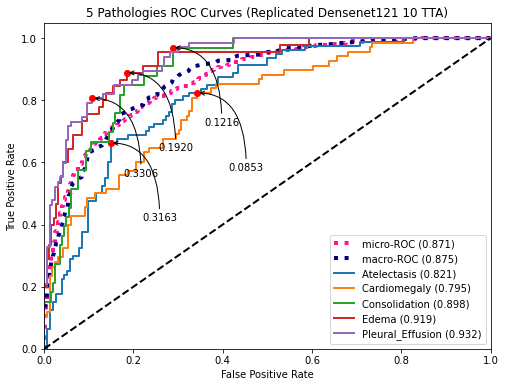

In [125]:
plot_roc(gtlabels, predval, C.TARGET5_INDEX, title_end='(Replicated Densenet121 10 TTA)')

In [126]:
np.mean([0.814,0.788,0.895,0.901,0.904,0.858])

0.8599999999999999

In [103]:
df_full_valid[C.TARGET_LABELS]

,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
CheX_Image_ID,,,,,,,,,,,,,,
221521,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221477,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
221663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221472,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
221695,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221577,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221657,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
221574,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


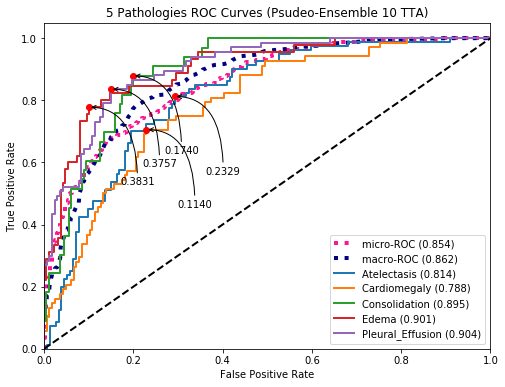

In [113]:
plot_roc(gt_labels, df_p10.values, C.TARGET5_INDEX, title_end='(Psudeo-Ensemble 10 TTA)')

## Save Predictions

output the test/validation results(just image ID and 14 fields with probabilities) to 6 files (3 models x 2 pops)

In [19]:
samp_savenames=['dn121_AP_72k_5e_chkpnt', 'dn121_PA_13k_5e_chkpnt', 'dn121_LL_14k_5e_chkpnt']
full_savenames=['dn121_AP_160k_5efull_chkpnt', 'dn121_PA_29k_5efull_chkpnt', 'dn121_LL_32k_5efull_chkpnt']

In [22]:
gidmap = {1:'AP', 2:'PA', 3:'LL'}
idgmap = {v:k for k,v in gidmap.items()}

In [29]:
def save_predictions(checkpoints, df, mdl_prefix='S', outdir=C.SAVE_PATH/'preds/'):
    dset = 'test' if len(df) == 234 else 'valid'
    for chkpnt in checkpoints: #enumerate(samp_savenames,1):
        projtype = chkpnt.split('_')[1] # BRITTLE
        projnum = idgmap[projtype]
        valid_loader = subset_dloader(df, projnum, False, 'Posit_ID', batch_size=64, print_tfms=False)
        base_model = CheXModel('densenet121',use_sig=True)
        df_pred = load_predict(base_model, chkpnt, valid_loader, False, DEVICE)
        outpath=outdir/f'{projnum}{projtype}_{mdl_prefix}model_{dset}.csv'
        df_pred.to_csv(outpath)
        print('Predictions saved to:',outpath.as_posix())

In [26]:
save_predictions(['dn121_LL_14k_5e_chkpnt'], df_valid, 'S')

Predictions saved to: save\preds\3LL_Smodel_Svalid.csv


In [30]:
save_predictions(samp_savenames, df_full_valid, 'S')

Predictions saved to: save/preds/1AP_Smodel_test.csv


Predictions saved to: save/preds/2PA_Smodel_test.csv


Predictions saved to: save/preds/3LL_Smodel_test.csv


In [31]:
save_predictions(full_savenames, df_full_valid, 'F')

Predictions saved to: save/preds/1AP_Fmodel_test.csv


Predictions saved to: save/preds/2PA_Fmodel_test.csv


Predictions saved to: save/preds/3LL_Fmodel_test.csv


In [12]:
torch.cuda.empty_cache()

In [15]:
test_loader = subset_dloader(df_full_valid, None, False, batch_size=64, print_tfms=False) 
base_model = CheXModel('densenet121',use_sig=True)
df_preds = load_predict(base_model,'dn121_TSlr256bSig_99k_script_scalsamp_chkpnt',test_loader,device=DEVICE)
df_preds.to_csv(C.SAVE_PATH/'preds/script_preds_Smodel_test.csv')
classwise_rocauc(df_full_valid,df_preds, C.TARGET13_LABELS)

,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
CheX_Image_ID,,,,,,,,,,,,,,
221521,0.104796,0.075268,0.022913,0.476681,0.034007,0.110435,0.164598,0.082695,0.506512,0.008134,0.106398,0.005168,0.016802,0.180649
221477,0.004357,0.044968,0.311924,0.711060,0.073533,0.488229,0.338547,0.295615,0.234516,0.014023,0.660193,0.006169,0.007712,0.330380
221663,0.303721,0.082281,0.015360,0.305613,0.019218,0.022451,0.091206,0.043565,0.450262,0.008600,0.117926,0.013244,0.020257,0.186876
221472,0.009826,0.108892,0.245689,0.763321,0.007924,0.062615,0.371922,0.073546,0.516243,0.015172,0.622054,0.002544,0.015121,0.254098
221695,0.018843,0.219075,0.215010,0.476967,0.016662,0.069574,0.139528,0.027631,0.483861,0.038985,0.596106,0.025742,0.020577,0.381817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221577,0.199158,0.156848,0.349206,0.285091,0.035578,0.065136,0.052045,0.054654,0.158247,0.009695,0.043037,0.041365,0.053537,0.067739
221657,0.006589,0.029655,0.058253,0.704823,0.012082,0.568609,0.288505,0.180751,0.456954,0.006997,0.752935,0.002180,0.012499,0.656899
221574,0.010454,0.095300,0.037433,0.666701,0.004355,0.235224,0.250222,0.058353,0.573027,0.016673,0.769726,0.002397,0.023409,0.800672
